In [2]:
import pandas as pd
import altair as alt
import numpy as np
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
sns.set_style("white")

alt.data_transformers.disable_max_rows()
# alt.data_transformers.enable('json')

DataTransformerRegistry.enable('default')

In [3]:
def subset(df,cols):
    """Takes a dataframe, columns to select from df as list (cols) and returns subsetted result.
    
    """
    
    return df[cols]

In [4]:
## Scores Data

df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')

cols_to_drop= ['id', 'name', 'first', 'last', 'compas_screening_date', 
               #'sex', 
               'dob',
               #'age', 
               'age_cat', 
               'race', 
               #'priors_count',
               #'decile_score',
               'juv_fel_count', 'juv_misd_count', 'juv_other_count',
                'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
                'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
                'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
                'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
                'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
                'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
                'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
                'decile_score.1', 'score_text', 'screening_date',
                'v_type_of_assessment', 'v_decile_score', 'v_score_text',
                'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
                'start', 'end', 'event', 
                #'two_year_recid'
              ]

## Data Filtering (matching ProPublica analysis)

In [5]:
df['race'].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

In [6]:
dfc = (
    df.where(df["days_b_screening_arrest"] <= 30, np.nan)
    .where(df["days_b_screening_arrest"] >= -30, np.nan)
    .where(df["is_recid"] != -1, np.nan)
    .where(df["c_charge_degree"] != "O", np.nan)
    .where(df["score_text"] != "N/A", np.nan)
    # Start Experiment
    # check to see what happens if we exclude all races except white and black
    .where(df["race"].isin(["African-American", "Caucasian"]), np.nan)
    .dropna(subset="race")
    # End Experiment
    .dropna(
        subset=["days_b_screening_arrest", "is_recid", "c_charge_degree", "score_text"]
    )
    .drop(columns=cols_to_drop)
    .rename(
        columns={
            "decile_score": "score",
            "priors_count": "priors",
            "two_year_recid": "recidivate",
        }
    )
    .replace({"Male": 0, "Female": 1})
    .astype(int, errors="ignore")  # .convert_dtypes() # Turn float columns to int
    .assign(
        recidivate=lambda x: x["recidivate"].astype(int)
    )  # Needed for weird reason; sklearn doesn't know about Int64 yet
    .reset_index(drop=True)
)

print(len(dfc))

# assert len(dfc) == 6172, "Does not match ProPublica analysis, check!"

5278


In [7]:
dfc

,sex,age,score,priors,recidivate
0,0,34,3,0,1
1,0,24,4,4,1
2,0,41,6,14,1
3,1,39,1,0,0
4,0,27,4,0,0
...,...,...,...,...,...
5273,0,30,2,0,1
5274,0,20,9,0,0
5275,0,23,7,0,0
5276,0,23,3,0,0


## Add Jitter so it's easier to interpret

## Try KNN

In [8]:
# Imports from sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [9]:
X = subset(dfc, ['age','priors','sex'])
y = subset(dfc, ['recidivate'])

In [10]:
X

,age,priors,sex
0,34,0,0
1,24,4,0
2,41,14,0
3,39,0,1
4,27,0,0
...,...,...,...
5273,30,0,0
5274,20,0,0
5275,23,0,0
5276,23,0,0


In [11]:
y

,recidivate
0,1
1,1
2,1
3,0
4,0
...,...
5273,1
5274,0
5275,0
5276,0


## Train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100,test_size=0.2)

## Feature Scaling

In [13]:
sc_X = StandardScaler()

X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Run KNN

In [14]:
# Define the model
classifier = KNeighborsClassifier(n_neighbors=11,p=2,metric='euclidean')

In [15]:
# Fit model
classifier.fit(X_train,y_train)

/Users/firasm/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=11)

## Predict results

In [16]:
y_pred = classifier.predict(X_test)

In [17]:
cm = confusion_matrix(y_test,y_pred)

In [18]:
cm

array([[397, 189],
       [171, 299]])

In [19]:
accuracy_score(y_test,y_pred)

0.6590909090909091

In [20]:
f1_score(y_test,y_pred)

0.6242171189979124

## Test Plot

<AxesSubplot:xlabel='age', ylabel='priors'>

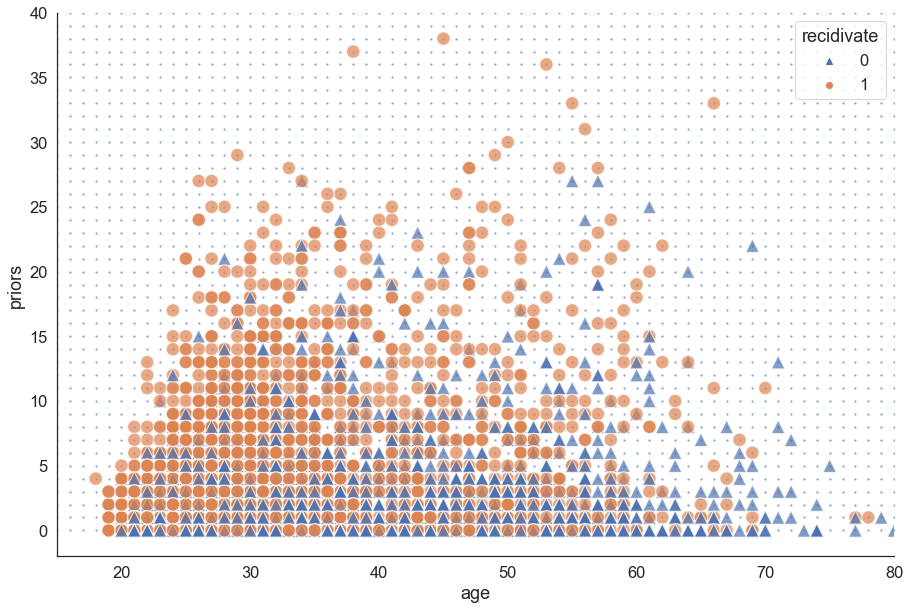

In [21]:
i = [j for j in range(0, 101)]
j = [i for i in range(0, 41)]
x = [[k] * len(j) for k in i]
flat_list = [item for sublist in x for item in sublist]

d = pd.DataFrame({"age": flat_list, "priors": j * len(i)})
d["grid"] = "grid"
d

fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x="age", y="priors", data=d, s=5, ax=ax, alpha=0.7)
ax.set_xlim(left=15, right=80)
ax.set_ylim(bottom=-2, top=40)
sns.despine()
sns.scatterplot(
    x="age",
    y="priors",
    hue="recidivate",
    style="recidivate",
    s=180,
    data=dfc.sample(frac=1),
    ax=ax,
    markers=["^", "o"],
    alpha=0.7,
)

## Setting up the toy dataset

In [22]:
new=pd.DataFrame([
    [0,19,0,1],
    [0,20,0,1],
    [0,21,0,1],
    [0,22,0,1],
    [0,22,3,1],
    [0,18,3,1],
    [1,18,1,1],
    [0,19,0,1],
    [0,20,1,1],
    [0,20,4,1],
    [0,20,2,1],
    [0,22,2,1],
    [0,25,1,1],
    [0,22,1,1],
    [0,18,5,1],
    [0,19,8,1],
    [0,21,9,1],
    [0,23,7,1],
    [0,22,10,1],
    [0,26,4,1],
             
    [0,30,3,0],
    [0,30,2,0],
    [1,45,1,0],
    [1,45,3,0],
    [1,40,1,0],
    [1,40,2,0],
    [0,36,0,0],
    [0,32,1,0],
    [0,40,0,0],
    [0,31,1,0],
    [0,35,3,0],
    [0,31,0,0],
    [0,32,0,0],
    [0,33,0,0],
    [0,40,7,0],
    [0,42,6,0],
    [0,35,4,0],
             ],columns=['sex','age','priors','recidivate'])

print(len(new))
new['grid'] = 'training'
new.head()

37


,sex,age,priors,recidivate,grid
0,0,19,0,1,training
1,0,20,0,1,training
2,0,21,0,1,training
3,0,22,0,1,training
4,0,22,3,1,training


In [23]:
toy = pd.concat([d,new])
toy.head()

,age,priors,grid,sex,recidivate
0,0,0,grid,NaN,NaN
1,0,1,grid,NaN,NaN
2,0,2,grid,NaN,NaN
3,0,3,grid,NaN,NaN
4,0,4,grid,NaN,NaN


## Do the Learning

In [84]:
sc_X = StandardScaler()

# Subset to get the actual training data (new)
X_train = sc_X.fit_transform(subset(toy[toy['grid']=='training'], ['age','priors']))
y_train = subset(toy[toy['grid']=='training'],['recidivate'])

# Subset the "test" data as the grid data
X_test = sc_X.transform(subset(toy[toy['grid']=='grid'], ['age','priors']))

# Define the model
classifier = KNeighborsClassifier(n_neighbors=3,p=2,metric='euclidean')

# Fit model
classifier.fit(X_train,y_train)

/Users/firasm/.pyenv/versions/3.10.2/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [85]:
## Predict results

y_pred = classifier.predict(X_test)
grid = pd.DataFrame(X_test,columns=['age','priors'])
grid['recidivate'] = y_pred
d['recidivate'] = y_pred

toy = pd.concat([d,new])
toy.head()

,age,priors,grid,recidivate,sex
0,0,0,grid,1.0,NaN
1,0,1,grid,1.0,NaN
2,0,2,grid,1.0,NaN
3,0,3,grid,1.0,NaN
4,0,4,grid,1.0,NaN


In [90]:
bg = (
    alt.Chart(toy[toy["grid"] == "grid"])
    .mark_square(size=100, opacity=0.2, clip=True)
    .encode(
        alt.X(
            "age",
            scale=alt.Scale(
                domain=[0, 50],
            ),
            axis=alt.Axis(grid=False),
        ),
        alt.Y("priors", scale=alt.Scale(domain=[0, 15]), axis=alt.Axis(grid=False)),
        alt.Color("recidivate:N"),
    )
)

chart = (
    alt.Chart(toy[toy["grid"] == "training"])
    .mark_point(size=50, opacity=1, clip=True)
    .encode(
        alt.X(
            "age",
            scale=alt.Scale(
                domain=[0, 50],
            ),
            axis=alt.Axis(grid=False)
        ),
        alt.Y("priors", scale=alt.Scale(domain=[0, 15]),axis=alt.Axis(grid=False)),
        alt.Color("recidivate:N"),
    )
)

chart+bg

alt.LayerChart(...)



https://github.com/data-8/textbook/blob/main/chapters/17/1/Nearest_Neighbors.ipynb